Importing libraries needed

In [73]:
import pandas as pd
import numpy as np
from sklearn import metrics as mt
from sklearn.cluster import KMeans
from sklearn import preprocessing
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
%matplotlib inline

#### Preprocessing and Feature selection

Load file from Disk

In [99]:

path = 'E:\\Work\\KDD Dataset\\kddcup.data_10_percent_corrected'

kdd = pd.read_csv(path,names= ["duration","protocol","service","flag","src-bytes","dst-bytes","land","wrong-fragment","urgent","hot","num-failed-login","logged_in","num_compromised","root_shell","su_attempted","num_root","num_file_creation","num_shells","num_access_files","num_outbound_cmds","is_host_login","is_guest_login","count","srv_count","serror_rate","srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate","diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count","dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate","dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate","dst_host_rerror_rate","dst_host_srv_rerror_rate","class"] )



Choosing variables that is most relevant for classification

In [100]:
kdd = kdd[["wrong-fragment",
           "src-bytes",
           "land",
           "service",
           "flag",
           "dst-bytes",
           "num-failed-login",
           "num_file_creation",
           "protocol",
           "duration",
           "is_guest_login",
           "dst_host_same_src_port_rate",
           "num_compromised",
           "hot",
           "dst_host_same_srv_rate",
           "dst_host_srv_count",
           "count",
           "num_shells",
           "dst_host_diff_srv_rate",
           "diff_srv_rate",
           "logged_in",
           "dst_host_rerror_rate",
           "serror_rate",
           "dst_host_count",
           "dst_host_srv_diff_host_rate",
           "srv_serror_rate",
           "class"]]

Removiing the categorical variables and target label to prepare for clustering

In [102]:
kdd_clust = kdd.drop(["service","flag","protocol","class"], axis=1)

Standerdizing the variables before clustering

In [103]:
kdd_clust_std = preprocessing.scale(kdd_clust)

##### Clustering using K-means

Drawing the elbow curve to determine the best number of K

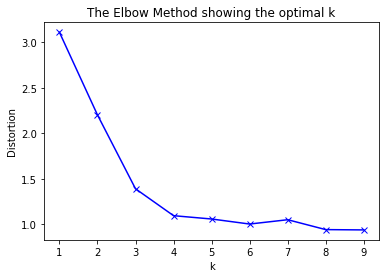

In [104]:
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(kdd_clust_std)
    distortions.append(sum(np.min(cdist(kdd_clust_std, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / kdd_clust_std.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

5 Clusters are the optimum number for K-means according to the minimum within distance

Now making a clustering model with 5 clusters

In [105]:
kmeanModel = KMeans(n_clusters=5)
kmeanModel.fit(kdd_clust_std)
cluster = kmeanModel.predict(kdd_clust_std)

adding the cluster label to each instance

In [107]:
kdd["cluster"] = pd.Series(cluster, index = kdd.index)

In [108]:
kdd["cluster"].value_counts()

0    292169
1     87430
4     82175
2     31561
3       686
Name: cluster, dtype: int64

Preparing dummy variables

In [109]:
kdd_service = pd.get_dummies(kdd['service'])
kdd = pd.concat([kdd, kdd_service], axis=1)
kdd = kdd.drop('service',axis=1)

kdd_flag = pd.get_dummies(kdd['flag'])
kdd = pd.concat([kdd, kdd_flag], axis=1)
kdd = kdd.drop('flag',axis=1)

kdd_protocol = pd.get_dummies(kdd['protocol'])
kdd = pd.concat([kdd, kdd_protocol], axis=1)
kdd = kdd.drop('protocol',axis=1)

kdd_cluster = pd.get_dummies(kdd['cluster'])
kdd = pd.concat([kdd, kdd_cluster], axis=1)
kdd = kdd.drop('cluster',axis=1)

#### Random Forest Classification

In [110]:
#X is the input data & y is the output column
X = kdd.drop('class',axis=1)
y = kdd['class']

In [111]:
# Splitting the dataset into the Training set and Test set
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

In [112]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [113]:
# Fitting Random Forest Classification to the Training set
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 0)
classifier.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [114]:
# Predicting the Test set results
y_pred = classifier.predict(X_test)

In [115]:
%config IPCompleter.greedy=True

In [116]:
# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
ac = mt.accuracy_score(y_test, y_pred)
ac

0.99973280650332774

In [117]:
fs = mt.f1_score(y_test, y_pred,average='micro')
fs

0.99973280650332774

In [118]:
ps = mt.precision_score(y_test, y_pred,average='macro')
ps

C:\Users\Andrew\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.78944132174544746

In [119]:
FP = cm.sum(axis=0) - np.diag(cm)  
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.sum() - (FP + FN + TP)

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)

TPR

C:\Users\Andrew\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


array([ 1.        ,  0.83333333,  1.        ,  0.94117647,  1.        ,
        0.9903537 ,  1.        ,  0.        ,         nan,  0.99996283,
        0.98113208,  0.9997525 ,  1.        ,  0.98461538,  1.        ,
        0.        ,  0.99238579,  1.        ,  0.        ,  1.        ,
        0.97435897,  0.6       ])

In [120]:
# Specificity or true negative rate

TNR = TN/(TN+FP) 
TNR

array([ 1.        ,  0.99997571,  1.        ,  1.        ,  0.9999919 ,
        1.        ,  1.        ,  1.        ,  0.99998381,  0.9999793 ,
        1.        ,  0.99976829,  1.        ,  1.        ,  0.99999189,
        1.        ,  0.99999188,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ])

In [121]:
# Precision or positive predictive value
PPV = TP/(TP+FP)
# Negative predictive value
NPV = TN/(TN+FN)
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)
# False discovery rate
FDR = FP/(TP+FP)

C:\Users\Andrew\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  
C:\Users\Andrew\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
C:\Users\Andrew\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


In [122]:
# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)
ACC

array([ 1.        ,  0.99996761,  1.        ,  0.9999919 ,  0.9999919 ,
        0.99997571,  1.        ,  0.99997571,  0.99998381,  0.99997571,
        0.9999919 ,  0.99976519,  1.        ,  0.9999919 ,  0.9999919 ,
        0.99996761,  0.99996761,  1.        ,  0.9999919 ,  1.        ,
        0.99995142,  0.99998381])

#### Classification Using Kernel SVM

In [123]:
# Splitting the dataset into the Training set and Test set
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

In [124]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [125]:
# Fitting Kernel SVM to the Training set
from sklearn.svm import SVC
classifier = SVC(kernel = 'rbf', random_state = 0)
classifier.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=0, shrinking=True,
  tol=0.001, verbose=False)

In [126]:
# Predicting the Test set results
y_pred = classifier.predict(X_test)

In [131]:
type(y_test)

pandas.core.series.Series

In [136]:
# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix,classification_report
cm = confusion_matrix(y_test, y_pred)
ac = mt.accuracy_score(y_test, y_pred)
ac

0.99882596796916745

In [137]:
classification_report(y_test, y_pred)

C:\Users\Andrew\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


'                  precision    recall  f1-score   support\n\n           back.       1.00      1.00      1.00       528\nbuffer_overflow.       0.67      0.33      0.44         6\n      ftp_write.       0.00      0.00      0.00         1\n   guess_passwd.       1.00      0.94      0.97        17\n           imap.       1.00      1.00      1.00         3\n        ipsweep.       0.99      0.90      0.94       311\n           land.       1.00      1.00      1.00         3\n     loadmodule.       0.00      0.00      0.00         3\n        neptune.       1.00      1.00      1.00     26907\n           nmap.       0.63      0.83      0.72        53\n         normal.       1.00      1.00      1.00     24242\n            phf.       0.00      0.00      0.00         1\n            pod.       1.00      1.00      1.00        65\n      portsweep.       1.00      0.93      0.97       268\n        rootkit.       0.00      0.00      0.00         4\n          satan.       0.98      0.97      0.98      